# Big Mountain Resort Modeling<a id='5_Modeling'></a>

## Imports<a id='5.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate

## Load Model<a id='5.4_Load_Model'></a>

In [2]:
expected_model_version = '1.0'
model_path = '../models/ski_resort_pricing_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

## Load Data<a id='5.5_Load_Data'></a>

In [3]:
ski_data = pd.read_csv('../data/ski_data_step3_features.csv')

In [4]:
big_mountain = ski_data[ski_data.Name == 'Big Mountain Resort']

In [5]:
big_mountain.T

,124
Name,Big Mountain Resort
Region,Montana
state,Montana
summit_elev,6817
vertical_drop,2353
base_elev,4464
trams,0
fastSixes,0
fastQuads,3
quad,2


In [6]:
X = ski_data.loc[ski_data.Name != "Big Mountain Resort", model.X_columns]
y = ski_data.loc[ski_data.Name != "Big Mountain Resort", 'AdultWeekend']

In [7]:
len(X), len(y)

(276, 276)

In [8]:
model.fit(X, y)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('standardscaler', None),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=69, n_jobs=None,
                                      

In [9]:
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [10]:
cv_results['test_score']

array([-12.06453416,  -9.26926482, -11.45943347,  -8.04190514,
       -10.9847141 ])

In [11]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(10.363970336909468, 1.4877934368360821)

In [12]:
X_bm = ski_data.loc[ski_data.Name == "Big Mountain Resort", model.X_columns]
y_bm = ski_data.loc[ski_data.Name == "Big Mountain Resort", 'AdultWeekend']

In [13]:
bm_pred = model.predict(X_bm).item()

In [14]:
y_bm = y_bm.values.item()

In [15]:
print(f'Big Mountain Resort modelled price is ${bm_pred:.2f}, actual price is ${y_bm:.2f}.')
print(f'Even with the expected mean absolute error of ${mae_mean:.2f}, this suggests there is room for an increase.')

Big Mountain Resort modelled price is $96.62, actual price is $81.00.
Even with the expected mean absolute error of $10.36, this suggests there is room for an increase.


## Big Mountain Resort In Market Context<a id='5.8_Big_Mountain_Resort_In_Market_Context'></a>

Features that came up as important in the modeling (not just our final, random forest model) included:
* vertical_drop
* Snow Making_ac
* total_chairs
* fastQuads
* Runs
* LongestRun_mi
* trams
* SkiableTerrain_ac

In [1]:
def plot_compare(feat_name, description, state=None, figsize=(10, 5)):
    """Graphically compare distributions of features.
    
    Plot histogram of values for all resorts and reference line to mark
    Big Mountain's position.
    
    Arguments:
    feat_name - the feature column name in the data
    description - text description of the feature
    state - select a specific state (None for all states)
    figsize - (optional) figure size
    """
    
    plt.subplots(figsize=figsize)
    # quirk that hist sometimes objects to NaNs, sometimes doesn't
    # filtering only for finite values tidies this up
    if state is None:
        ski_x = ski_data[feat_name]
    else:
        ski_x = ski_data.loc[ski_data.state == state, feat_name]
    ski_x = ski_x[np.isfinite(ski_x)]
    plt.hist(ski_x, bins=30)
    plt.axvline(x=big_mountain[feat_name].values, c='r', ls='--', alpha=0.8, label='Big Mountain')
    plt.xlabel(description)
    plt.ylabel('frequency')
    plt.title(description + ' distribution for resorts in market share')
    plt.legend()

### Ticket price<a id='5.8.1_Ticket_price'></a>

Look at where Big Mountain sits overall amongst all resorts for price and for just other resorts in Montana.

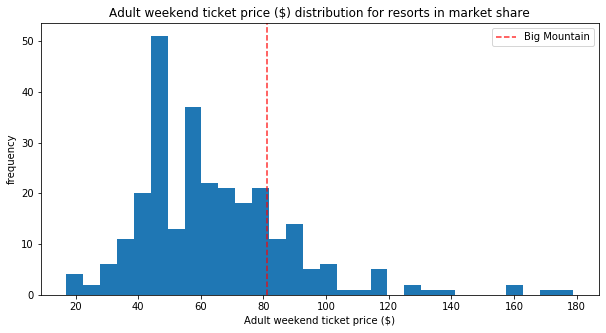

In [17]:
plot_compare('AdultWeekend', 'Adult weekend ticket price ($)')


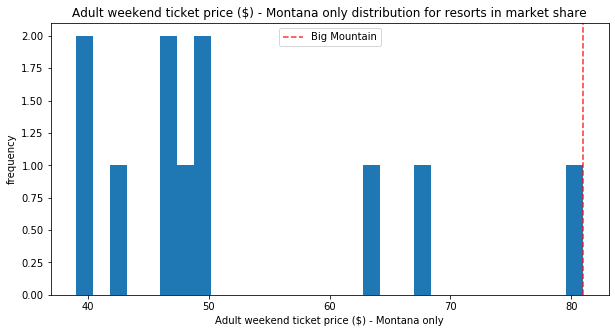

In [18]:
plot_compare('AdultWeekend', 'Adult weekend ticket price ($) - Montana only', state='Montana')

### Vertical drop<a id='5.8.2_Vertical_drop'></a>

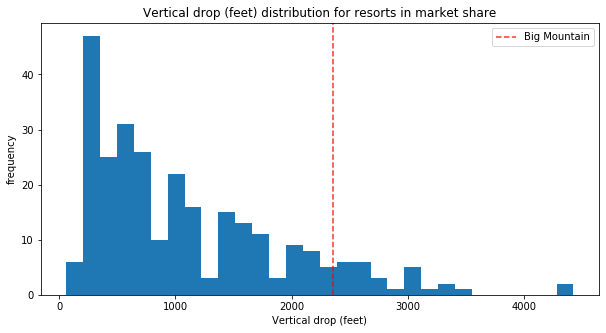

In [19]:
plot_compare('vertical_drop', 'Vertical drop (feet)')

Big Mountain is doing well for vertical drop, but there are still quite a few resorts with a greater drop.

### Snow making area<a id='5.8.3_Snow_making_area'></a>

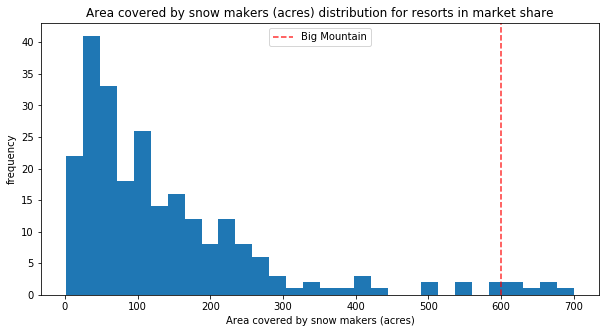

In [20]:
plot_compare('Snow Making_ac', 'Area covered by snow makers (acres)')

Big Mountain is very high up the league table of snow making area.

### Total number of chairs<a id='5.8.4_Total_number_of_chairs'></a>

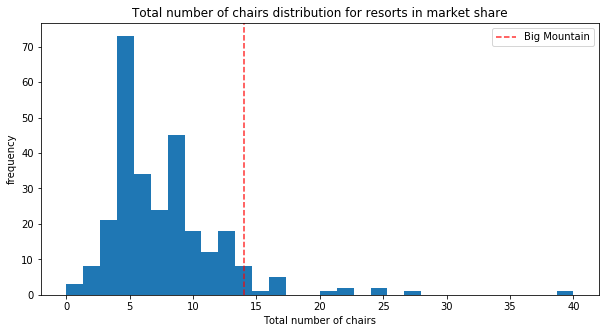

In [22]:
plot_compare('total_chairs', 'Total number of chairs')

Big Mountain has amongst the highest number of total chairs, resorts with more appear to be outliers.

### Fast quads<a id='5.8.5_Fast_quads'></a>

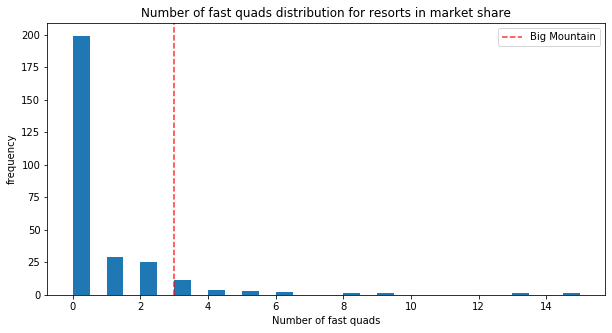

In [23]:
plot_compare('fastQuads', 'Number of fast quads')

Most resorts have no fast quads. Big Mountain has 3, which puts it high up that league table. There are some values  much higher, but they are rare.

### Runs<a id='5.8.6_Runs'></a>

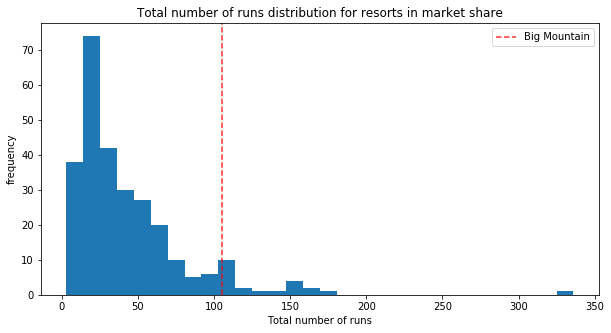

In [24]:
plot_compare('Runs', 'Total number of runs')

Big Mountain compares well for the number of runs. There are some resorts with more, but not many.

### Longest run<a id='5.8.7_Longest_run'></a>

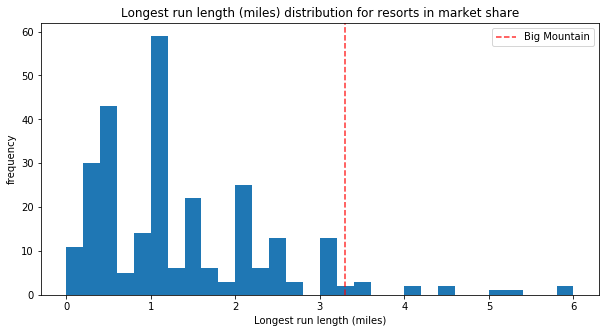

In [25]:
plot_compare('LongestRun_mi', 'Longest run length (miles)')

Big Mountain has one of the longest runs. Although it is just over half the length of the longest, the longer ones are rare.

### Trams<a id='5.8.8_Trams'></a>

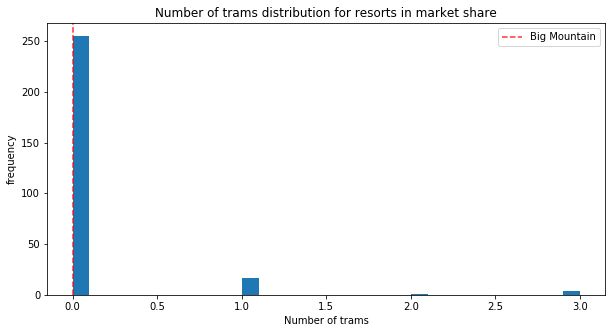

In [26]:
plot_compare('trams', 'Number of trams')

The vast majority of resorts, such as Big Mountain, have no trams.

### Skiable terrain area<a id='5.8.9_Skiable_terrain_area'></a>

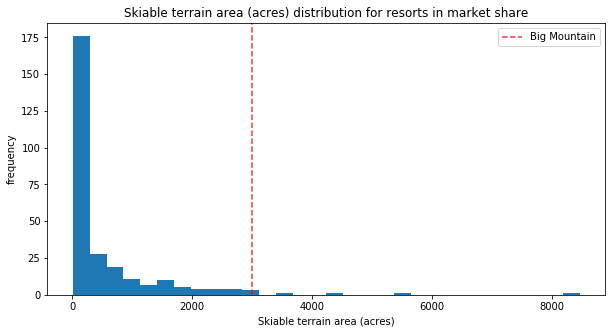

In [27]:
plot_compare('SkiableTerrain_ac', 'Skiable terrain area (acres)')

Big Mountain is amongst the resorts with the largest amount of skiable terrain.

## Modeling scenarios<a id='5.9_Modeling_scenarios'></a>

Big Mountain Resort has been reviewing potential scenarios for either cutting costs or increasing revenue (from ticket prices). Ticket price is not determined by any set of parameters; the resort is free to set whatever price it likes. However, the resort operates within a market where people pay more for certain facilities, and less for others. Being able to sense how facilities support a given ticket price is valuable business intelligence. This is where the utility of our model comes in.

The business has shortlisted some options:
1. Permanently closing down up to 10 of the least used runs. This doesn't impact any other resort statistics.
2. Increase the vertical drop by adding a run to a point 150 feet lower down but requiring the installation of an additional chair lift to bring skiers back up, without additional snow making coverage
3. Same as number 2, but adding 2 acres of snow making cover
4. Increase the longest run by 0.2 mile to boast 3.5 miles length, requiring an additional snow making coverage of 4 acres

The expected number of visitors over the season is 350,000 and, on average, visitors ski for five days. Assume the provided data includes the additional lift that Big Mountain recently installed.

In [28]:
expected_visitors = 350_000

In [29]:
all_feats = ['vertical_drop', 'Snow Making_ac', 'total_chairs', 'fastQuads', 
             'Runs', 'LongestRun_mi', 'trams', 'SkiableTerrain_ac']
big_mountain[all_feats]

,vertical_drop,Snow Making_ac,total_chairs,fastQuads,Runs,LongestRun_mi,trams,SkiableTerrain_ac
124,2353,600.0,14,3,105.0,3.3,0,3000.0


In [2]:
def predict_increase(features, deltas):
    """Increase in modelled ticket price by applying delta to feature.
    
    Arguments:
    features - list, names of the features in the ski_data dataframe to change
    deltas - list, the amounts by which to increase the values of the features
    
    Outputs:
    Amount of increase in the predicted ticket price
    """
    
    bm2 = X_bm.copy()
    for f, d in zip(features, deltas):
        bm2[f] += d
    return model.predict(bm2).item() - model.predict(X_bm).item()

### Scenario 1<a id='5.9.1_Scenario_1'></a>

Close up to 10 of the least used runs. The number of runs is the only parameter varying.

In [31]:
[i for i in range(-1, -11, -1)]

[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10]

In [32]:
runs_delta = [i for i in range(-1, -11, -1)]
price_deltas = [predict_increase(['Runs'], [delta]) for delta in runs_delta]

In [33]:
price_deltas

[0.0,
 -0.4057971014492665,
 -0.6666666666666572,
 -0.6666666666666572,
 -0.6666666666666572,
 -1.4637681159420168,
 -1.4637681159420168,
 -1.4637681159420168,
 -1.9130434782608603,
 -1.9130434782608603]

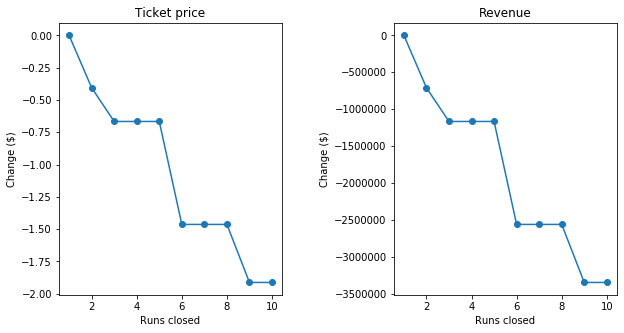

In [34]:
runs_closed = [-1 * x for x in runs_delta] #1
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)
ax[0].plot(runs_closed, price_deltas, 'o-')
ax[0].set(xlabel='Runs closed', ylabel='Change ($)', title='Ticket price')
revenue_deltas = [5 * expected_visitors * a for a in price_deltas] #2
ax[1].plot(runs_closed, revenue_deltas, 'o-')
ax[1].set(xlabel='Runs closed', ylabel='Change ($)', title='Revenue');

The model says closing one run makes no difference. Closing 2 and 3 successively reduces support for ticket price and so revenue. If Big Mountain closes down 3 runs, it seems they may as well close down 4 or 5 as there's no further loss in ticket price. Increasing the closures down to 6 or more leads to a large drop. 

### Scenario 2<a id='5.9.2_Scenario_2'></a>

In this scenario, Big Mountain is adding a run, increasing the vertical drop by 150 feet, and installing an additional chair lift.

In [36]:
ticket2_increase = predict_increase(['Runs', 'vertical_drop', 'total_chairs'], [1, 150, 1])
revenue2_increase = 5 * expected_visitors * ticket2_increase

In [37]:
print(f'This scenario increases support for ticket price by ${ticket2_increase:.2f}')
print(f'Over the season, this could be expected to amount to ${revenue2_increase:.0f}')

This scenario increases support for ticket price by $1.94
Over the season, this could be expected to amount to $3398551


### Scenario 3<a id='5.9.3_Scenario_3'></a>

In this scenario, you are repeating the previous one but adding 2 acres of snow making.

In [39]:
ticket3_increase = predict_increase(['Runs', 'vertical_drop', 'total_chairs', 'Snow Making_ac'], [1, 150, 1, 2])
revenue3_increase = 5 * expected_visitors * ticket3_increase

In [40]:
print(f'This scenario increases support for ticket price by ${ticket3_increase:.2f}')
print(f'Over the season, this could be expected to amount to ${revenue3_increase:.0f}')

This scenario increases support for ticket price by $1.94
Over the season, this could be expected to amount to $3398551


Such a small increase in the snow making area makes no difference!

### Scenario 4<a id='5.9.4_Scenario_4'></a>

This scenario calls for increasing the longest run by .2 miles and guaranteeing its snow coverage by adding 4 acres of snow making capability.

In [41]:
#Code task 6#
#Predict the increase from adding 0.2 miles to `LongestRun_mi` and 4 to `Snow Making_ac`
predict_increase(['LongestRun_mi', 'Snow Making_ac'], [0.2, 4])

0.0

No difference whatsoever. Although the longest run feature was used in the linear model, the random forest model (the one we chose because of its better performance) only has longest run way down in the feature importance list. 

## Summary<a id='5.10_Summary'></a>

Currently, Big Mountain charges 81.00 dollars per ticket for their resort. According to the model that price should be at 94.22 dollars, a difference of 13.22 dollars per ticket. Even with a mean standard error of 10.39 that still leaves room to increase ticket price. For my approach I would definitely rely on the model when telling the company how they should increase their price, but I would also break down more specific aspects of the resort that they could also improve the overall profitability of.

I would suggest closing at least one run and ideally 6-10 of their least used runs. The model suggests that if one run was closed there would be no difference in revenue. If 2-3 runs are closed revenue is reduced by the same amount, then again for 4-5 runs. After 6 runs though, there isn’t as much of a drop so it may be more profitable to keep 6-10 of the least used runs closed unless they are at max capacity.

Other suggestions would be to lower the vertical drop of a particular run by 150 feet. This would reduce the need for additional and more expensive lift chairs. You could also add 2 acres of snow making cover, which is proven to be a feature of top resorts around the country. These changes, along with the closing runs suggestion would significantly increase Big Mountain’s total revenue.


## Further work<a id='5.11_Further_work'></a>

This data was very good, however there were a few deficiencies. All we have are the other resorts prices, which we assume are as accurately priced as our model is trying to be. Some of the other resorts could be undercharging on their ticket costs because they have expensive rental or hotel fees, we can’t really tell with the data we have. 

I think the model’s prices are much higher than Big Mountain’s current prices because the business leaders at Big Mountain weren’t aware of how much they had to offer. According to the analysis above, Big Mountain consistently ranks with the top resorts around the country with some of the best features. The model sees this and gives fair prices for what the people are paying for.

I believe this model works really well for determining a good price for both the business and their customers. There is plenty of opportunity for revenue growth which should make the business leaders of Big Mountain very happy. I believe that this model should work well for now and for the future, if any additional data comes up it should be relatively easy to implement and create new features to make the model better.
